# Tariff recommendation

Task: Build the model with the *accuracy* value at least 0.75.

* calls — number of calls,
* minutes — total duration of calls in minutes,
* messages — number of sms messages,
* mb_used - Internet traffic used in Mb,
* is_ultra - what tariff did you use during the month ("Ultra" - 1, "Smart" - 0).

## Open and examine the file

In [35]:
import pandas as pd
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from seaborn import pairplot
import seaborn
from sklearn.model_selection import GridSearchCV
import warnings
from sklearn.dummy import DummyClassifier
warnings.filterwarnings('ignore')

In [36]:
df = pd.read_csv('datasets/users_behavior.csv')

In [37]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [39]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


In [40]:
df.corr(method='pearson')

,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.982083,0.177385,0.286442,0.207122
minutes,0.982083,1.000000,0.173110,0.280967,0.206955
messages,0.177385,0.173110,1.000000,0.195721,0.203830
mb_used,0.286442,0.280967,0.195721,1.000000,0.198568
is_ultra,0.207122,0.206955,0.203830,0.198568,1.000000


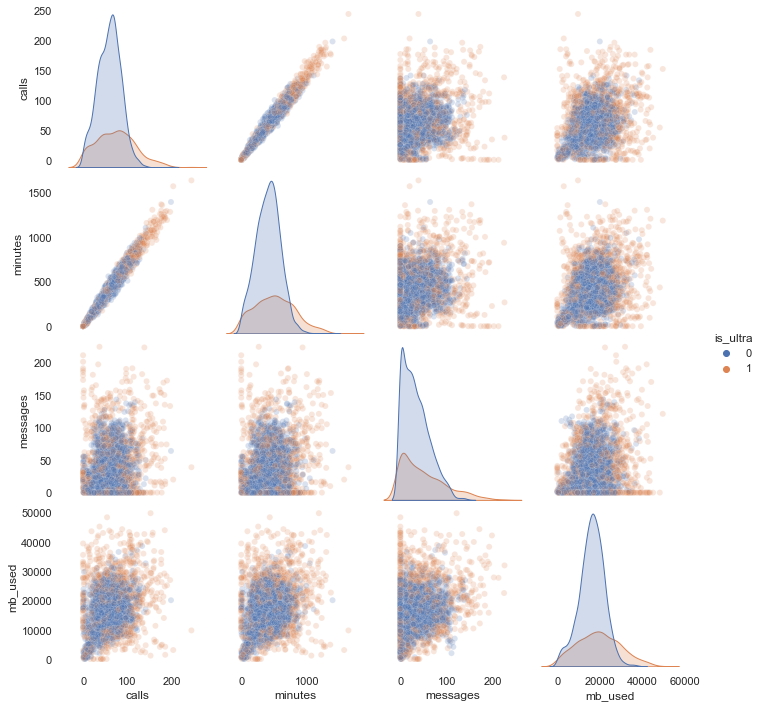

In [41]:
seaborn.set(rc={'axes.facecolor':'white'})
pairplot(df, hue="is_ultra", plot_kws={'alpha':0.2})

**Conclusions**

1. Data loaded, no missing values. About 30% use the ultra tariff
2. Ultra indicators are more widely dispersed 
3. High correlation only between number of calls and talk time. The risk of multicollinearity

## Divide into subsamples

In [42]:
df_train, df_valid = train_test_split(df, test_size=0.4, random_state=12345,
                                      stratify=df['is_ultra']) 
df_valid, df_test = train_test_split(df_valid, test_size=0.5, random_state=12345,
                                     stratify=df_valid['is_ultra']) 

In [43]:
display(df_train.describe())
display(df_test.describe())
display(df_valid.describe())

,calls,minutes,messages,mb_used,is_ultra
count,1928.00000,1928.000000,1928.000000,1928.000000,1928.000000
mean,63.14834,439.494528,38.798755,17298.083148,0.306535
std,32.94829,230.865152,36.524703,7525.581677,0.461174
min,0.00000,0.000000,0.000000,0.000000,0.000000
25%,41.00000,280.367500,9.000000,12666.895000,0.000000
50%,62.00000,431.675000,30.000000,17079.040000,0.000000
75%,81.00000,566.532500,58.000000,21280.010000,1.000000
max,244.00000,1632.060000,224.000000,49745.730000,1.000000


,calls,minutes,messages,mb_used,is_ultra
count,643.000000,643.000000,643.000000,643.000000,643.000000
mean,61.547434,424.119285,37.654743,17313.866345,0.306376
std,34.151789,243.930240,36.366243,7749.638301,0.461347
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37.000000,248.710000,7.500000,12576.680000,0.000000
50%,60.000000,418.750000,28.000000,17061.330000,0.000000
75%,82.500000,563.935000,55.000000,21824.460000,1.000000
max,184.000000,1354.750000,201.000000,44296.860000,1.000000


,calls,minutes,messages,mb_used,is_ultra
count,643.000000,643.000000,643.000000,643.000000,643.000000
mean,64.202177,448.443064,37.356143,16830.393997,0.306376
std,33.166523,235.759228,34.796772,7525.888524,0.461347
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,41.500000,287.515000,11.000000,11969.960000,0.000000
50%,64.000000,443.010000,29.000000,16544.650000,0.000000
75%,84.000000,588.940000,55.000000,21085.675000,1.000000
max,203.000000,1566.450000,223.000000,42986.700000,1.000000


In [44]:
features_train = df_train.drop('is_ultra', axis=1)
target_train = df_train['is_ultra']
features_valid = df_valid.drop('is_ultra', axis=1)
target_valid = df_valid['is_ultra']
features_test = df_valid.drop('is_ultra', axis=1)
target_test = df_valid['is_ultra']
features_df = df.drop('is_ultra', axis=1)
target_df = df['is_ultra']

**Conclusions**

1. The sample is divided in proportion 60/20/20. There are differences between the samples, but they are small.

## Building models

### Decision Tree

In [45]:
model = DecisionTreeClassifier(max_depth=2, random_state=12345)
model.fit(features_train, target_train)
valid_predictions = model.predict(features_valid)
accuracy = accuracy_score(target_valid, valid_predictions) 

In [46]:
accuracy

0.7729393468118196

In [47]:
text_representation = export_text(model)
print(text_representation)

|--- feature_3 <= 24925.54
|   |--- feature_0 <= 102.50
|   |   |--- class: 0
|   |--- feature_0 >  102.50
|   |   |--- class: 1
|--- feature_3 >  24925.54
|   |--- feature_3 <= 29078.21
|   |   |--- class: 1
|   |--- feature_3 >  29078.21
|   |   |--- class: 1



[Text(418.5, 453.0, 'mb_used <= 24925.54\ngini = 0.425\nsamples = 1928\nvalue = [1337, 591]\nclass = 0'),
 Text(209.25, 271.8, 'calls <= 102.5\ngini = 0.366\nsamples = 1666\nvalue = [1265, 401]\nclass = 0'),
 Text(104.625, 90.59999999999997, 'gini = 0.327\nsamples = 1537\nvalue = [1221, 316]\nclass = 0'),
 Text(313.875, 90.59999999999997, 'gini = 0.449\nsamples = 129\nvalue = [44, 85]\nclass = 1'),
 Text(627.75, 271.8, 'mb_used <= 29078.215\ngini = 0.399\nsamples = 262\nvalue = [72, 190]\nclass = 1'),
 Text(523.125, 90.59999999999997, 'gini = 0.481\nsamples = 137\nvalue = [55, 82]\nclass = 1'),
 Text(732.375, 90.59999999999997, 'gini = 0.235\nsamples = 125\nvalue = [17, 108]\nclass = 1')]

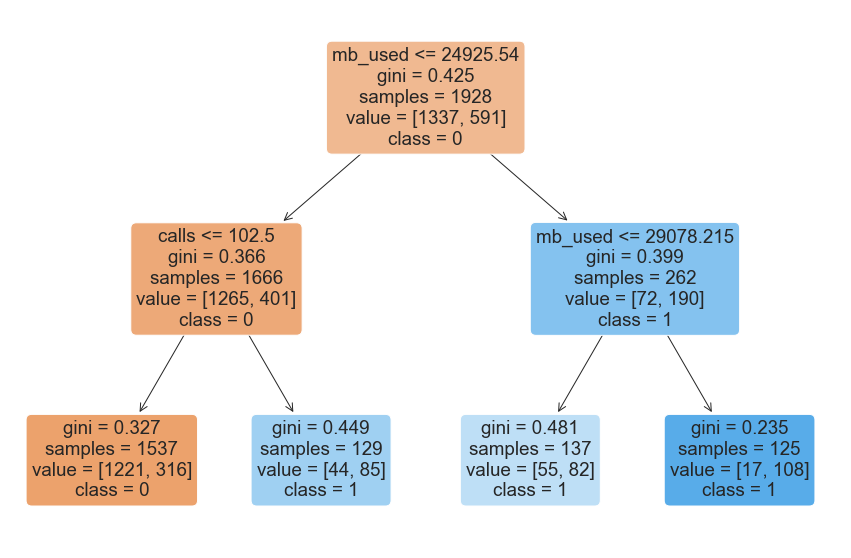

In [48]:
fig = plt.figure(figsize=(15, 10))
plot_tree(model, 
          feature_names=features_train.columns,
          class_names = ['0', '1'],
          filled=True, impurity=True, 
          rounded=True)

In [49]:
for depth in range(1, 20):
    model = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    model.fit(features_train, target_train)
    valid_predictions = model.predict(features_valid)
    accuracy = accuracy_score(target_valid, valid_predictions) 
    print("Depth:", depth, 'Accuracy:', accuracy)

Depth: 1 Accuracy: 0.7402799377916018
Depth: 2 Accuracy: 0.7729393468118196
Depth: 3 Accuracy: 0.7776049766718507
Depth: 4 Accuracy: 0.7542768273716952
Depth: 5 Accuracy: 0.7853810264385692
Depth: 6 Accuracy: 0.7744945567651633
Depth: 7 Accuracy: 0.7869362363919129
Depth: 8 Accuracy: 0.80248833592535
Depth: 9 Accuracy: 0.7822706065318819
Depth: 10 Accuracy: 0.7729393468118196
Depth: 11 Accuracy: 0.7620528771384136
Depth: 12 Accuracy: 0.7527216174183515
Depth: 13 Accuracy: 0.744945567651633
Depth: 14 Accuracy: 0.7558320373250389
Depth: 15 Accuracy: 0.7480559875583204
Depth: 16 Accuracy: 0.7387247278382582
Depth: 17 Accuracy: 0.7153965785381027
Depth: 18 Accuracy: 0.7076205287713841
Depth: 19 Accuracy: 0.7045101088646968


### Random forest

Best decision tree model with depth 2-3 - 0.785 and 8 - 0.8

In [50]:
x = pd.DataFrame(columns=('depth', 'est', 'result', 'result_test'))
for depth in range(1, 6):
    for est in range(1, 11):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth = depth) 
        model.fit(features_train, target_train) 
        result = model.score(features_valid, target_valid)
#        print("Depth:", depth, "Number of trees:", est, 'Accuracy:', result)
        result_train = model.score(features_train, target_train)
        x = x.append(pd.DataFrame([[depth, est, result, result_train]], columns=x.columns))

In [51]:
x['diff'] = x['result_test'] - x['result']
x.sort_values(by='result', ascending=False).head(10)

,depth,est,result,result_test,diff
0,3,7,0.796267,0.798237,0.001969
0,3,6,0.794712,0.799274,0.004562
0,5,8,0.794712,0.821058,0.026346
0,3,10,0.794712,0.797718,0.003006
0,3,9,0.794712,0.798755,0.004043
0,3,8,0.793157,0.796162,0.003005
0,4,10,0.791602,0.806017,0.014415
0,3,5,0.791602,0.797199,0.005597
0,3,2,0.790047,0.794606,0.004559
0,5,4,0.790047,0.815353,0.025306


### LogisticRegression

In [52]:
model = LogisticRegression(random_state=12345)  
model.fit(features_train, target_train)
result = model.score(features_valid, target_valid) 
result

0.7387247278382582

**Results**

1. 3 models were built. Logistic gives the lowest accuracy 0.75, decision tree - 0.785-0.8. The best model is random forest 0.8+.
2. Among the random forest, the best option showed the variant with a depth of 5 and 10 trees, but for further work we will take 4 and 8 - the drop in accuracy is small, but the difference between the test validation and training sets is minimal - less risk of overfitting)

In [53]:
param_grid ={'max_depth': range(1, 10), 'n_estimators':range(1, 10), 'random_state': [12345]}  
grid = GridSearchCV(RandomForestClassifier(), param_grid, refit = True, n_jobs = -1, verbose=5) 
grid.fit(features_train, target_train) 
print(grid.best_params_) 

Fitting 5 folds for each of 81 candidates, totalling 405 fits
{'max_depth': 9, 'n_estimators': 9, 'random_state': 12345}


In [54]:
model = RandomForestClassifier(random_state=12345, n_estimators=7, max_depth = 5) 
model.fit(features_train, target_train) 
result = model.score(features_valid, target_valid)
result

0.7838258164852255

## Check the model on the test set

In [55]:
model = RandomForestClassifier(random_state=12345, n_estimators=8, max_depth = 4) 
model.fit(features_train, target_train) 
result = model.score(features_train, target_train)
print(result)
result = model.score(features_valid, target_valid)
print(result)
result = model.score(features_test, target_test)
print(result)

0.8003112033195021
0.7807153965785381
0.7807153965785381


In [56]:
features_tr_val = pd.concat([features_train, features_valid])
target_tr_val = pd.concat([target_train, target_valid])

In [57]:
model = RandomForestClassifier(random_state=12345, n_estimators=8, max_depth = 4) 
model.fit(features_tr_val, target_tr_val) 
result = model.score(features_train, target_train)
print(result)
result = model.score(features_valid, target_valid)
print(result)
result = model.score(features_test, target_test)
print(result)

0.8054979253112033
0.8118195956454122
0.8118195956454122


**Conclusions**

1. The model showed the required  accuracy result 
